ARBRES DE DECISION: 

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

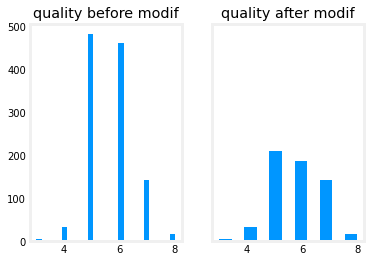

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2)
print(X_norm2)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test =train_test_split(wine_df.drop('quality',axis=1), wine_df['quality'], test_size=.3,
 #                                                  random_state=22)
#X_train.shape,X_test.shape

In [34]:
def entropy(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    
print(entropy(0.5))

1.0


In [68]:
def split_indices(X, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[index_feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

def split_indices_continue(X,t, index_feature):
    """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that have 
    that feature = 1 and the right node those that have the feature = 0 
    index feature = 0 => ear shape
    index feature = 1 => face shape
    index feature = 2 => whiskers
    """
    left_indices = []
    right_indices = []
    for i,x in enumerate(X):
        if x[0,index_feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
    return left_indices, right_indices

In [157]:
X_train=X_norm2
y_train=y_train2
left,right=split_indices_continue(X_train,0.5, 0)
print(X_train)
print(len(left),len(right))

[[ 0.93933222 -0.96338181 -0.57365783 -1.36502663]
 [-1.39978919 -0.59360107 -0.45623467  1.48339955]
 [ 0.93933222 -0.96338181 -0.57365783 -1.36502663]
 ...
 [ 1.16210569  1.07041225 -0.57365783 -0.90724385]
 [ 0.49378528 -0.87093663  0.95284319 -0.9581086 ]
 [ 0.10393172  0.70063152  0.60057372 -0.8563791 ]]
450 146


on peut utiliser l'entrepie, mais on va utilsier le critère de gini impurity

In [158]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    print(p_left)
    p_right = sum(y[right_indices])/len(right_indices)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

def weighted_entropy_continue(X,y,left_indices,right_indices,threshold_y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)

    #calcul p_left et p_right : moyenne de Y>threshold_y(qualité du vin) (moyenne d'un tableau de 1 0 1 00 1...)
    p_left=np.mean(y[left_indices]>=threshold_y)
    p_right=np.mean(y[right_indices]>=threshold_y)
    
    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    print(tab_value)

    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity

In [159]:
left_indices, right_indices = split_indices_continue(X_train,0.5, 0)
gini_Impurity(y_train)

[  0.   0.   0.   6.  33. 210. 188. 143.  16.]


0.7148945993423721

In [160]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

def information_gain_continue(X, y, left_indices, right_indices, threshold_y):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node=np.mean(y[left_indices]>=threshold_y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy_continue(X,y,left_indices,right_indices,threshold_y)
    return h_node - w_entropy

In [161]:
information_gain_continue(X_train, y_train, left_indices, right_indices,5)

-0.10627911837247811

In [162]:
for i, feature_name in enumerate(X_features):
    left_indices, right_indices = split_indices_continue(X_train, 0.5,i)
    i_gain = information_gain_continue(X_train, y_train, left_indices, right_indices,5)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")

Feature: volatile acidity, information gain if we split the root node using this feature: -0.11
Feature: alcohol, information gain if we split the root node using this feature: 0.03
Feature: sulphates, information gain if we split the root node using this feature: 0.06
Feature: citric acid, information gain if we split the root node using this feature: 0.06


code for binary classification

In [163]:
def compute_entropy(y):

    entropy = 0
    
    if len(y) == 0:
        return 0
    entropy = sum(y[y==1])/len(y)
    if entropy == 0 or entropy == 1:
        return 0
    else:
        return -entropy*np.log2(entropy) - (1-entropy)*np.log2(1-entropy)
     

def split_dataset(X, node_indices, feature):

    left_indices = []
    right_indices = []

    for i in node_indices:
        if X[i][feature] == 1:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 
def compute_information_gain(X, y, node_indices, feature):
    
    left_indices, right_indices = split_dataset(X, node_indices, feature)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain
def get_best_split(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    for feature in range(num_features):
        info_gain = compute_information_gain(X, y, node_indices, feature)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_feature = feature
    print("max_info_gain",max_info_gain)
   
    return best_feature
def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   

    best_feature = get_best_split(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))
    

    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))
    
    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

code for multi classification

In [171]:
def gini_Impurity(y):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    #on calcul le nombre de valeur par note de vin (0 à 8)
    tab_value=np.zeros(9)
    for loop in range(len(y)):
        tab_value[y[loop]]+=1
    #print(tab_value)

    #calcul de l'impureté
    impurity=1
    for loop in range(len(tab_value)):
        impurity-=(tab_value[loop]/sum(tab_value))**2
    return impurity
     
    
def split_dataset_continue(X, node_indices, feature,t):

    left_indices = []
    right_indices = []
    #print("t",t)
    for i in node_indices:
        #print(X[i,feature])
        if X[i,feature] <= t:
            left_indices.append(i)
        else:
            right_indices.append(i)
        
    return left_indices, right_indices 

def compute_information_gain_continue(X, y, node_indices, feature, t):
    
    left_indices, right_indices = split_dataset_continue(X, node_indices, feature,t)
    
    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]
    
    information_gain = 0
    
    node_entropy = gini_Impurity(y_node)
    left_entropy = gini_Impurity(y_left)
    right_entropy = gini_Impurity(y_right)
    w_left = len(X_left) / len(X_node)
    w_right = len(X_right) / len(X_node)
    weighted_entropy = w_left * left_entropy + w_right * right_entropy
    information_gain = node_entropy - weighted_entropy
    
    return information_gain
def get_best_split_continue(X, y, node_indices):   
    num_features = X.shape[1]
    
    best_feature = -1

    max_info_gain = 0
    tmax=0

    tab_max_feature=np.zeros(num_features)
    tab_min_feature=np.zeros(num_features)
    for loop in range(num_features):
        tab_max_feature[loop]=np.max(np.transpose(X)[loop])
        tab_min_feature[loop]=np.min(np.transpose(X)[loop])
    
    for feature in range(num_features):
        tab_t_feature=np.linspace(tab_min_feature[feature], tab_max_feature[feature], len(X)-1)
        for t in range(len(tab_t_feature)):
            #print(t,X_features[feature])
            info_gain = compute_information_gain_continue(X, y, node_indices, feature,tab_t_feature[t])
            #print(tab_t_feature[t],X_features[feature],info_gain)
            if info_gain > max_info_gain:
                max_info_gain = info_gain
                best_feature = feature
                tmax=tab_t_feature[t]
    print("max_info_gain",max_info_gain,X_features[best_feature],tmax)
   
    return best_feature,tmax
def build_tree_recursive_continue(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return
   

    best_feature,tmax = get_best_split_continue(X, y, node_indices) 
    
    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %s" % (formatting, current_depth, branch_name, X_features[best_feature]))
    print("split with ",X_features[best_feature]," <= ",tmax)

    left_indices, right_indices = split_dataset_continue(X, node_indices, best_feature,tmax)
    tree.append((left_indices, right_indices, best_feature,tmax))
    
    build_tree_recursive_continue(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive_continue(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

In [173]:
tree = []
print(X_train)
root_indices=list(range(0, len(X_train)))
build_tree_recursive_continue(X_train, y_train,root_indices, "Root", max_depth=2, current_depth=0, tree = tree)

[[ 0.93933222 -0.96338181 -0.57365783 -1.36502663]
 [-1.39978919 -0.59360107 -0.45623467  1.48339955]
 [ 0.93933222 -0.96338181 -0.57365783 -1.36502663]
 ...
 [ 1.16210569  1.07041225 -0.57365783 -0.90724385]
 [ 0.49378528 -0.87093663  0.95284319 -0.9581086 ]
 [ 0.10393172  0.70063152  0.60057372 -0.8563791 ]]


/tmp/ipykernel_31902/3348463916.py:14: RuntimeWarning: invalid value encountered in double_scalars
  impurity-=(tab_value[loop]/sum(tab_value))**2


max_info_gain 0.07487931829161631 alcohol 0.23871685382930918
 Depth 0, Root: Split on feature: alcohol
split with  alcohol  <=  0.23871685382930918
max_info_gain 0.03768815421926175 sulphates -0.6200142753667681
- Depth 1, Left: Split on feature: sulphates
split with  sulphates  <=  -0.6200142753667681
  -- Left leaf node with indices [3, 5, 6, 12, 16, 22, 27, 28, 30, 34, 39, 40, 44, 50, 54, 57, 58, 63, 64, 65, 66, 73, 74, 76, 85, 119, 122, 123, 147, 148, 157, 167, 184, 185, 218, 219, 220, 227, 228, 229, 231, 233, 246, 247, 256, 257, 258, 259, 261, 262, 263, 268, 269, 274, 276, 277, 278, 279, 281, 283, 287, 292, 294, 296, 306, 307, 311, 312, 313, 316, 359, 361, 362, 366, 367, 369, 370, 378, 385, 386, 437, 449, 453, 464, 468, 479, 493, 495, 496, 497, 498, 499, 500, 501, 503, 510, 512, 519, 526, 543, 544, 548, 553, 560, 580, 581, 582, 583, 585]
  -- Right leaf node with indices [0, 1, 2, 4, 7, 8, 9, 10, 11, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 29, 31, 32, 33, 35, 36, 37, 38, 41, 42, 

[([0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   47,
   48,
   50,
   51,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   80,
   81,
   85,
   86,
   87,
   88,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   105,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   125,
   126,
   130,
   131,
   132,
   134,
   135,
   136,
   137,
   138,
   139,
   141,
   147,
   148,
   149,
   152,
   153,
   155,
   156,
   157,
   158,
   163,
   164,
   166,
   167,
   169,
   172,
  

TREE ENSEMBLES : RANDOM FOREST POUR LA QUALITE DU VIN

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

prep données

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0               7.4             0.700         0.00             1.9      0.076  \
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1138            6.3             0.510         0.13             2.3      0.076   
1139            6.8             0.620         0.08             1.9      0.068   
1140            6.2             0.600         0.08             2.0      0.090   
1141            5.9             0.550         0.10             2.2      0.062   
1142            5.9             0.645         0.12             2.0      0.075   

      free sulfur dioxide  

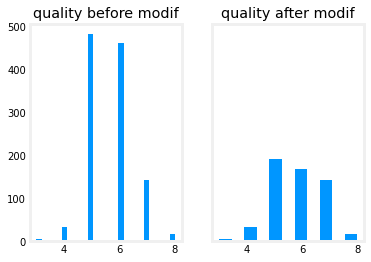

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')
print(df)
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y_train = df['quality']
X_train= [df['volatile acidity'],df['alcohol'],df['sulphates'],df['citric acid']]
X_features = ['volatile acidity','alcohol','sulphates','citric acid']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)


def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(X_norm)
import random
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality before modif")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality after modif")

print(y_train2.shape)
print(X_norm2.shape)

In [3]:
X_train=X_norm2
y_train=y_train2
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
print(int(len(y_train)*0.8)) ## Let's use 80% to train and 20% to eval

from sklearn.preprocessing import LabelEncoder
print(y_train)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print(y_train)

447
[5 6 5 7 7 5 7 5 5 5 6 5 6 6 7 4 6 4 5 6 5 5 4 5 6 5 4 5 5 5 4 5 5 5 5 5 6
 6 5 5 7 5 5 5 5 5 6 4 5 5 5 4 6 5 4 4 6 5 5 6 5 5 6 4 7 7 7 5 5 6 7 5 7 7
 6 5 5 5 7 5 4 4 8 6 6 6 8 7 7 7 6 7 7 6 6 5 5 5 5 6 6 5 7 7 6 7 7 6 5 7 6
 6 5 5 6 6 7 7 7 7 5 7 7 6 6 8 5 7 6 5 5 6 7 4 6 5 7 7 7 7 7 5 6 8 7 7 5 5
 6 6 7 8 5 3 5 6 5 6 5 8 6 6 7 7 6 8 5 8 6 6 7 7 7 7 7 6 7 6 6 7 7 5 6 3 5
 5 6 5 5 6 7 5 5 6 5 6 6 6 5 5 5 6 6 6 6 4 5 5 6 5 7 8 6 5 6 5 6 6 5 5 5 5
 6 6 6 4 5 4 7 5 5 7 6 5 5 5 5 5 5 5 5 6 6 4 4 5 6 5 5 5 5 6 5 5 5 5 5 6 5
 5 6 6 5 6 5 6 5 5 5 6 6 5 6 5 7 5 7 7 5 6 4 7 5 7 4 4 7 7 7 5 5 6 7 7 5 5
 4 7 6 6 6 6 7 7 7 7 7 6 6 6 6 5 7 4 5 7 7 7 7 7 7 7 7 7 7 7 7 6 6 5 6 6 7
 5 7 6 5 5 7 7 7 7 7 7 5 6 7 6 5 6 7 7 5 7 7 7 6 6 6 5 5 7 6 7 5 7 7 8 6 7
 7 7 5 7 7 7 7 7 8 6 7 6 5 6 6 6 6 7 5 7 8 7 5 7 7 7 6 5 6 6 7 6 6 6 7 7 7
 7 6 6 4 6 5 4 5 7 6 6 7 8 7 7 5 7 7 6 6 6 6 6 5 5 7 6 6 4 4 5 5 5 5 6 4 6
 6 6 6 5 6 4 7 6 6 6 5 5 5 5 3 5 6 6 6 6 6 5 5 6 5 6 6 5 5 5 5 6 5 6 6 6 5
 6 5 5 5 8 6 7 6 6 6 

In [4]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [5]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-mlogloss:1.71506


/home/henri/.local/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.65175
[2]	validation_0-mlogloss:1.59988
[3]	validation_0-mlogloss:1.56101
[4]	validation_0-mlogloss:1.52425
[5]	validation_0-mlogloss:1.49162
[6]	validation_0-mlogloss:1.46611
[7]	validation_0-mlogloss:1.44765
[8]	validation_0-mlogloss:1.43042
[9]	validation_0-mlogloss:1.41832
[10]	validation_0-mlogloss:1.40874
[11]	validation_0-mlogloss:1.40257
[12]	validation_0-mlogloss:1.39479
[13]	validation_0-mlogloss:1.38973
[14]	validation_0-mlogloss:1.38570
[15]	validation_0-mlogloss:1.37859
[16]	validation_0-mlogloss:1.37371
[17]	validation_0-mlogloss:1.36740
[18]	validation_0-mlogloss:1.35963
[19]	validation_0-mlogloss:1.35460
[20]	validation_0-mlogloss:1.35176
[21]	validation_0-mlogloss:1.34938
[22]	validation_0-mlogloss:1.34726
[23]	validation_0-mlogloss:1.34511
[24]	validation_0-mlogloss:1.34286
[25]	validation_0-mlogloss:1.34107
[26]	validation_0-mlogloss:1.34306
[27]	validation_0-mlogloss:1.34294
[28]	validation_0-mlogloss:1.34530
[29]	validation_0-mlogloss:1.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [6]:
xgb_model.best_iteration

25

In [8]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}")

print(xgb_model.classes_)
#print(xgb_model.classes_)

Metrics train:
	Accuracy score: 0.8211
Metrics test:
	Accuracy score: 0.8211
[0 1 2 3 4 5]
